In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

import pickle

from tmu.models.autoencoder.autoencoder import TMAutoEncoder
from src.lib.care import calculate_care_score

In [11]:
# Create folder figures if it does not exist
os.makedirs("figures", exist_ok=True)

In [12]:
def load_test_dataset(farm, event_id):
    X = np.loadtxt(f"./data_test/X_{farm}_{event_id}.txt", dtype=np.uint32)
    X = np.array(X).astype(np.uint32)

    # Take the first 3000 rows
    #X = X[:3000]

    return X


def load_thresh_dataset(farm, event_id):
    X = np.loadtxt(f"./data_train/X_{farm}_{event_id}.txt", dtype=np.uint32)
    X = np.array(X).astype(np.uint32)

    # Take the first 5000 rows
    X = X[:10000]

    return X


def load_test_labels(farm, event_id):
    # Load dataframe from file
    df = pd.read_csv(f"./data_test/y_{farm}_{event_id}.csv")

    labels = df['label'].values
    status_ids = df['status_type_id'].values
    train_test = df['train_test'].values

    # Take the first 3000 rows
    #labels = labels[:3000]
    #status_ids = status_ids[:3000]
    #train_test = train_test[:3000]

    return np.array(labels).astype(np.uint32), np.array(status_ids).astype(np.uint32), train_test


def load_test_label(farm, event_id):
    event_info = pd.read_csv(f"../../../data/care_to_compare/Wind Farm {farm}/event_info.csv", delimiter=';')

    metadata = event_info[event_info['event_id'] == event_id]

    event_label = metadata["event_label"].values[0]

    return False if event_label == "anomaly" else True

In [13]:
def load_model(filename) -> TMAutoEncoder:
    with open(filename, "rb") as f:
        model = pickle.load(f)

    return model

In [14]:
def calculate_accuracy(labels, predictions):
    # Calculate the accuracy
    accuracy = np.sum(labels == predictions) / len(labels)

    return accuracy


def calculate_threshold(X, pred):
    losses = [hamming_loss(X[i], pred[i]) for i in range(len(X))]

    # Set the threshold as the lowest 1% of the losses
    threshold = np.percentile(losses, 85)

    return threshold


In [15]:
def hamming_loss(pred, X_test):
    """
    Computes the Hamming loss between predicted and ground truth binary arrays.

    Parameters:
    - pred (numpy array): Binary predictions of shape (n_samples, n_bits).
    - X_test (numpy array): Ground truth binary values of shape (n_samples, n_bits).

    Returns:
    - float: Hamming loss (fraction of incorrect bits).
    """
    assert pred.shape == X_test.shape, "Shapes of pred and X_test must match"

    # Compute the number of differing bits
    incorrect_bits = np.sum(pred != X_test)

    # Total number of bits
    total_bits = np.prod(X_test.shape)

    # Hamming loss is the fraction of incorrect bits
    return incorrect_bits / total_bits

In [16]:
def reconstruction_accuracy(X, pred):
    correct = np.sum(X == pred)
    accuracy = correct / len(X)
    return accuracy


def plot_mse(X, y, pred, name, threshold):
    # Compute MSE for each row
    mse_per_row = [hamming_loss(X[i], pred[i]) for i in range(len(X))]

    # Plot SNS plot of all MSE values
    plt.figure(figsize=(8, 4))
    sns.histplot(mse_per_row, bins=50, kde=True, color='b')

    # Add a threshold line
    plt.axvline(threshold, color='r', linestyle='--')

    # Save the plot
    plt.savefig(f"./figures/plot_reconstruction_acc_{name}.png")

    plt.close()


def plot_predictions(X, y, z, pred, p, name, threshold):
    x = np.arange(0, len(X))  # Time or index
    r = [hamming_loss(X[i], pred[i]) for i in range(len(X))]

    anomalies = np.array([1 if (p[i] == 1 and z[i] == 0) else 0 for i in range(len(X))])

    y_mapped = np.where(y == 0, -0.2, -0.1)
    a_mapped = np.where(anomalies == 0, -0.4, -0.3)
    p_mapped = np.where(p == 0, -0.6, -0.5)
    z_mapped = np.where(np.logical_or(z == 0, z == 2), -0.8, -0.7)

    # Create a figure with two subplots (1 row, 2 columns)
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # First chart
    # If z is 0 or 2, then the color is orange, if y[i] is 1, then the color is red, otherwise blue
    colors = ['red' if y[i] == 1 else 'blue' if z[i] == 0 or z[i] == 2 else 'orange' for i in range(len(z))]

    axes[0].scatter(x, r, label="Reconstruction Loss", c=colors, alpha=0.7)
    axes[0].axhline(threshold, color='red', linestyle='--', label="Threshold")

    axes[0].set_title("Reconstruction Loss")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Reconstruction Loss")
    axes[0].legend()

    # Second chart
    axes[1].plot(x, y_mapped, label="Actual Anomalies (y)", color='red', linestyle='-', linewidth=2)
    axes[1].plot(x, a_mapped, label="Detected Anomalies (a)", color='purple', linestyle='-', linewidth=2)
    axes[1].plot(x, p_mapped, label="Predicted Anomalies (p)", color='green', linestyle='-', linewidth=2)
    axes[1].plot(x, z_mapped, label="Status Type Id (z)", color='orange', linestyle='-', linewidth=2)

    axes[1].axhline(y=-0.1, color='black', linestyle='dotted', linewidth=1, alpha=0.5)
    axes[1].axhline(y=-0.2, color='black', linestyle='dotted', linewidth=1, alpha=0.5)
    axes[1].axhline(y=-0.3, color='black', linestyle='dotted', linewidth=1, alpha=0.5)
    axes[1].axhline(y=-0.4, color='black', linestyle='dotted', linewidth=1, alpha=0.5)
    axes[1].axhline(y=-0.5, color='black', linestyle='dotted', linewidth=1, alpha=0.5)
    axes[1].axhline(y=-0.6, color='black', linestyle='dotted', linewidth=1, alpha=0.5)
    axes[1].axhline(y=-0.7, color='black', linestyle='dotted', linewidth=1, alpha=0.5)
    axes[1].axhline(y=-0.8, color='black', linestyle='dotted', linewidth=1, alpha=0.5)

    axes[1].set_ylim(-0.9, 0)

    axes[1].set_title("Anomalies")
    axes[1].legend()

    # Adjust layout
    plt.tight_layout()
    plt.grid(True)

    plt.show()

    # Save the plot
    plt.savefig(f"./figures/plot_detections_{name}.png")

    plt.close()


def get_predictions(X, y, z, name, tm, threshold):
    pred = tm.predict(X)

    # For each row in pred, if the MSE is greater than the threshold, then it is an anomaly
    losses = [hamming_loss(X[i], pred[i]) for i in range(len(X))]

    X_predictions = np.array([1 if losses[i] > threshold else 0 for i in range(len(X))])

    # Accuracy
    accuracy = calculate_accuracy(y, X_predictions)

    plot_mse(X, y, pred, name, threshold)
    plot_predictions(X, y, z, pred, X_predictions, name, threshold)

    return X_predictions, accuracy

In [17]:
test_datasets = [68, 22, 72, 73, 0, 26, 40, 42, 10, 45, 84, 25, 69, 13, 24, 3, 17, 38, 71, 14, 92, 51]

tm_autoencoder = load_model("models/latest_14_full.pkl")

X_thresh = load_thresh_dataset("A", 25)
X_thresh_pred = tm_autoencoder.predict(X_thresh)

threshold = calculate_threshold(X_thresh, X_thresh_pred)

print(f"Threshold: {threshold}")


def run_prediction(farm, dataset):
    X = load_test_dataset(farm, dataset)
    labels, status_ids, train_test = load_test_labels(farm, dataset)

    is_normal = load_test_label(farm, dataset)

    predictions, accuracy = get_predictions(X, labels, status_ids, f"{farm}_{dataset}", tm_autoencoder, threshold)

    return X, labels, status_ids, train_test, is_normal, predictions, accuracy


Threshold: 0.2518518518518518


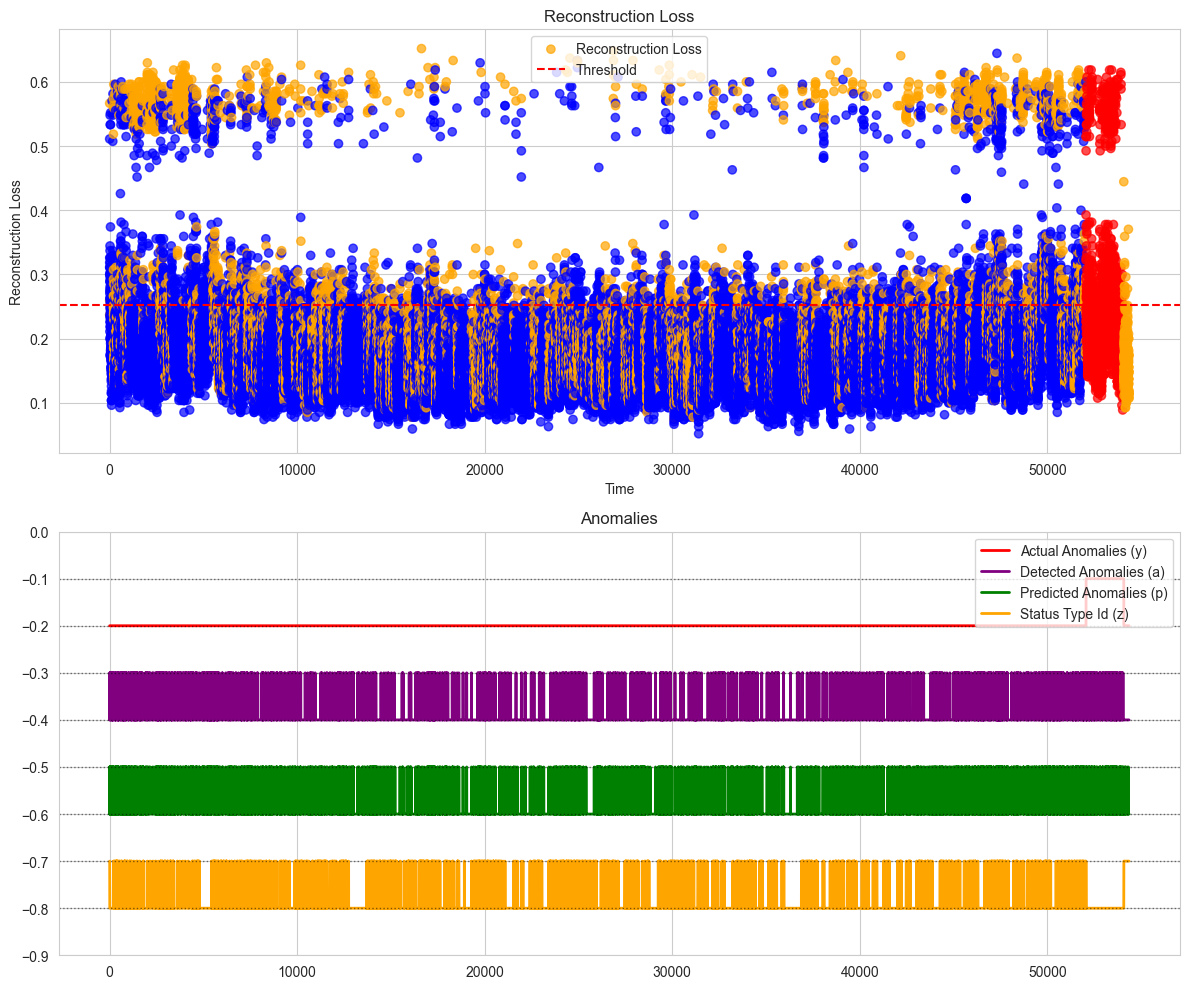

Done with 68. Accuracy: 0.8801464365870709


In [ ]:
# Create a dataframe with status_type_id;label;prediction
elements = []

for set in test_datasets:
    res = run_prediction("A", set)

    result_df = pd.DataFrame({
        'status_type_id': res[2],
        'label': res[1],
        'prediction': res[5],
        'train_test': res[3],
    })

    print(f"Done with {set}. Accuracy: {res[6]}")

    elements.append({'dataset': set, 'normal': res[4], 'data': result_df, 'accuracy': res[6]})

In [65]:
# Safe the results to results.pkl
with open("results_full_99.pkl", "wb") as f:
    pickle.dump(elements, f)

In [66]:
# filter out 45
elements_to_filter_out = [45, 84]
elements_to_process = [elem for elem in elements if elem['dataset'] not in elements_to_filter_out]

score = calculate_care_score(elements_to_process)
print(score)

0.6944988592924013


In [67]:
# Trained on only two 5 bit datasets: 0.6807648486258542
# Trained on all 5 bit datasets: X.XX